# Hyperparameter tuning for MLP
Given the results in `04-mlp-for-pressure` We use Keras tuning API to find the best hyperparameters for the MLP model. 
We will gauge the following hyperparameters:
- Number of layers
- Number of neurons in each layer
- Activation function
- Optimizer



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Input

In [15]:
DROP = [
    'link_type', 'velocity', 'status', 'start_node', 'end_node',
    'node_type', 'x_pos', 'y_pos', 'head_value',
    'leak_area_value', 'leak_discharge_value', 'leak_demand_value', 'has_leak',
]
TARGET = 'pressure_value'

In [16]:
def extract_data(path):
    dataset = pd.read_csv(path, sep=';')
    dataset = dataset.drop(columns=set(dataset.columns).intersection(DROP))
    dataset['hour'] = dataset['hour'].apply(lambda x: int(x.split(':')[0]))
    dataset = dataset.rename(columns={'nodeID': 'ID', 'linkID': 'ID'})
    dataset = dataset.set_index(['hour', 'ID']).unstack(level=1)
    return dataset


def load_data(edges=False):
    # Load the data
    data_edges = extract_data('../dati/networks/dataset-network-out/NET_0_bd_0_005_h_720_leak_area_0_links.csv')
    data_nodes = extract_data('../dati/networks/dataset-network-out/NET_0_bd_0_005_h_720_leak_area_0_nodes.csv')
    data = pd.concat([data_edges, data_nodes], axis=1)
    if not edges:
        # Remove data from the pipes
        data = data.drop(columns=['flowrate'], level=0)
    return data


def scale_data(data):
    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data, scaler


def add_noise(data):
    # Add noise to the data
    noise = np.random.normal(0, 1e-4, data.shape)
    return data + noise

Using ['flowrate', 'base_demand', 'demand_value', 'pressure_value'] features for nodes [550000, 550001, 550002, 550003, 550004, 550005, 550006, 550007, 550008, 550009, 550010, 550011, 550012, 550013, 550014, 550015, 880000, 880001, 880002, 880003, 880004, 880005, 880006, 880007, 880008, 880009, 880010, 880011, 880012]


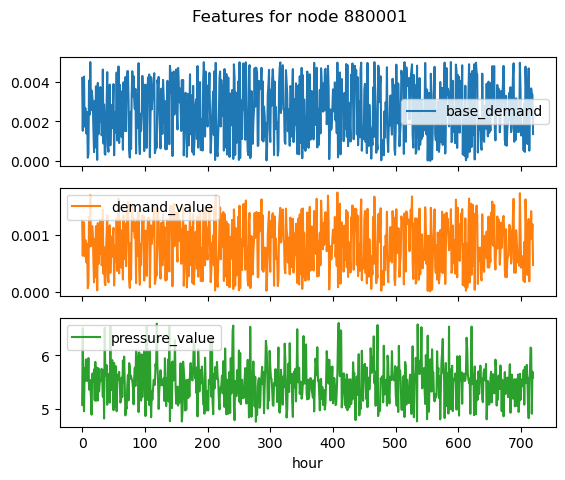

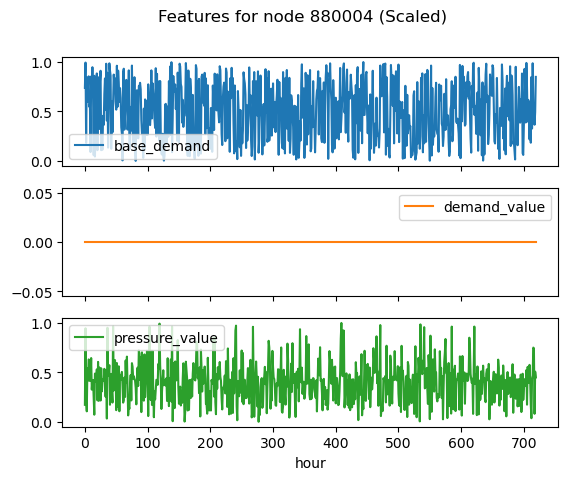

In [17]:
data = load_data(edges=True)
print(f"Using {list(data.columns.get_level_values(0).unique())} features for nodes {list(data.columns.get_level_values(1).unique())}")

scaled_data, scaler = scale_data(data)
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

data.xs(880001, level='ID', axis=1).plot(subplots=True, sharex=True, title="Features for node 880001")
scaled_data.xs(880004, level='ID', axis=1).plot(subplots=True, sharex=True, title="Features for node 880004 (Scaled)")
plt.show()

In [18]:
data_to_use = scaled_data
# Split the data in a features dataset and a target dataset
X, y = data_to_use.drop(columns=[TARGET], level=0), data_to_use[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on tensors of shape {X_train.shape} and {y_train.shape}")

Training on tensors of shape (576, 42) and (576, 13)


In [19]:
def create_neural_network(X, y):
    # Take all the different elements in the network
    elements = np.unique(X.columns.get_level_values(1))
    # Take all the different features of each element in the network
    features = np.unique(X.columns.get_level_values(0))
    print(f"Creating Neural Network with {len(features)} features from {len(elements)} elements.")

    # Create the Neural Network
    NN = Sequential()
    NN.add(Input(shape=(len(X.columns),)))

    # NN.add(Dense(len(elements) * len(elements), activation='relu'))
    NN.add(Dense(100, activation='relu'))
    NN.add(Dense(100, activation='relu'))
    # Add the output layer
    NN.add(Dense(len(y.columns), activation='sigmoid'))
    return NN

In [20]:
NN = create_neural_network(X_train, y_train)
# Compile the Neural Network
NN.compile(optimizer='adam', loss='mean_squared_error')

# Train the Neural Network
NN.fit(X_train, y_train, batch_size=100, epochs=10)

# Test the Neural Network
y_pred = NN.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

Creating Neural Network with 3 features from 29 elements.
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0597
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0445
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0342
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0272
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0206
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Overall Mean Squared Error for each node: 0.003862690805608766
Overall R2 Score for each node: 0.8905966985634352


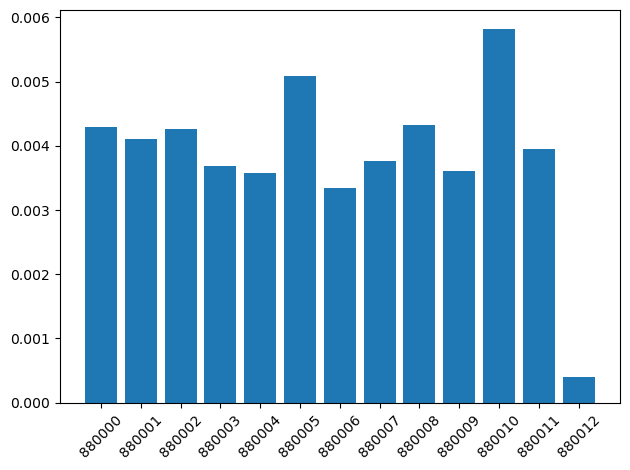

In [34]:
# Compute Mean Squared Error and R2 Score for every node
nodes_mse = mean_squared_error(y_test, y_pred, multioutput="raw_values", squared=True)
r2 = r2_score(y_test, y_pred, multioutput="variance_weighted")
print(f"Overall Mean Squared Error for each node: {nodes_mse.mean()}\n"
      f"Overall R2 Score for each node: {r2}")

fig, ax = plt.subplots(tight_layout=True)
x = [str(n) for n in y_test.columns]
ax.bar(x, nodes_mse)
ax.set_xticks(x, x, rotation=45)
plt.show()